In [2]:
from fastai2.vision.all import *

In [3]:
torch

<module 'torch' from '/home/tyoc213/miniconda3/envs/fastai2/lib/python3.7/site-packages/torch/__init__.py'>

https://github.com/pytorch/pytorch/issues/34086

Code from 

* https://github.com/pytorch/pytorch/blob/2f840b1662b487d5551d7230f8eb4d57645cfff5/test/test_autograd.py
* https://github.com/pytorch/pytorch/blob/2f840b1662b487d5551d7230f8eb4d57645cfff5/test/test_autograd.py
* https://github.com/pytorch/pytorch/blob/9600ed9af3b84c000b7f54765495e96f29c4bf1d/torch/autograd/profiler.py
* https://github.com/pytorch/pytorch/issues/19420
* https://github.com/pytorch/pytorch/issues/19422
* https://github.com/pytorch/pytorch/search?q=export_chrome_trace&type=Issues

Forum

* https://discuss.pytorch.org/t/interpreting-data-from-torch-autograd-profiler-profile/34390/4
* https://discuss.pytorch.org/t/proper-way-to-enable-and-disable-autograd-profiler/89773


## Importar lo necesario

In [4]:
from torch.autograd.profiler import (profile, format_time, EventList,
                                     FunctionEvent, FunctionEventAvg,
                                     record_function, emit_nvtx)

In [22]:
class Some():
    def assertTrue(self, v): return v
    def assertFalse(self, v): return not v
    def assertEqual(self, a, b): return a == b
    
    def test_profiler_tracing(self):
        t1, t2 = torch.ones(1), torch.ones(1)
        with torch.autograd.profiler.profile() as prof:
            torch.add(t1, t2)

        with tempfile.NamedTemporaryFile(mode="w+") as f:
            print("export to chrome")
            prof.export_chrome_trace(f.name)
            # read the trace and expect valid json
            # if the JSON generated by export_chrome_trace is not valid, this will throw and fail the test.
            parsed = json.load(f)
            print(f"pintando json de chrome {f.name}")
            print(json.dumps(parsed, indent=4, sort_keys=True))

        # Same test but for cuda.
        if not torch.cuda.is_available():
            return

        device = torch.device("cuda:0")
        t1, t2 = torch.ones(1, device=device), torch.ones(1, device=device)
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
            torch.add(t1, t2)

        with tempfile.NamedTemporaryFile(mode="w+") as f:
            prof.export_chrome_trace(f.name)
            # Now validate the json
            parsed = json.load(f)
            print(f"pintando json de chrome {f.name}")
            print(json.dumps(parsed, indent=4, sort_keys=True))


    def test_profiler(self):
        x = torch.randn(10, 10)

        with profile() as p:
            self.assertTrue(torch.autograd._profiler_enabled())
            y = x * 2 + 4

        self.assertFalse(torch.autograd._profiler_enabled())

        last_end = 0
        names = ['aten::mul', 'aten::to', 'aten::empty_strided', 'aten::copy_',
                 'aten::empty', 'aten::add', 'aten::to', 'aten::empty_strided',
                 'aten::copy_', 'aten::empty']
        top_level_names = ['aten::mul', 'aten::add']
        top_level_iter = iter(top_level_names)
        self.assertEqual(len(p.function_events), len(names))
        for info, expected_name in zip(p.function_events, names):
            if info.cpu_interval.start > last_end:
                print(top_level_iter)
                top_level_name_expected = next(top_level_iter)
                self.assertEqual(info.name, top_level_name_expected)
                last_end = info.cpu_interval.end
            self.assertEqual(info.name, expected_name)

    def test_profiler_unboxed_only(self):
        x = torch.rand(3, 4)

        with torch.autograd.profiler.profile() as prof:
            x.resize_([3, 2])

#    @skipIfRocm
    def test_profiler_custom_op(self):
        inst = torch.classes._TorchScriptTesting._PickleTester([3, 4])

        with torch.autograd.profiler.profile() as prof:
            torch.ops._TorchScriptTesting.take_an_instance(inst)

        found_event = False
        for e in prof.function_events:
            if e.name == '_TorchScriptTesting::take_an_instance':
                found_event = True
        self.assertTrue(found_event)

    def test_profiler_propagation(self):
        def foo(x):
            with record_function("in_foo") as rf:
                return x * 2

        x = torch.rand(3, 4)
        traced_foo = torch.jit.trace(foo, x)

        def bar(x):
            with record_function("in_bar") as rf:
                # we expect that profiler will be able
                # propagate across fork
                fut = torch.jit._fork(traced_foo, x)
                y = torch.jit._wait(fut)
                # note: continuation (and rf's end) can
                # be executed in a different thread
                with record_function("in_bar_after_wait") as rf2:
                    y = y * 2
                return y

        traced_bar = torch.jit.trace(bar, x)

        with profile() as p:
            traced_bar(x)

        found_foo = False
        found_bar = False
        found_bar_after_wait = False
        for info in p.function_events:
            if info.name == "in_foo":
                self.assertFalse(found_foo)
                found_foo = True
            elif info.name == "in_bar":
                self.assertFalse(found_bar)
                found_bar = True
            elif info.name == "in_bar_after_wait":
                self.assertFalse(found_bar_after_wait)
                found_bar_after_wait = True
        self.assertTrue(found_foo)
        self.assertTrue(found_bar)
        self.assertTrue(found_bar_after_wait)

    def test_record_function_callbacks(self):
        x = torch.randn(10, 10)
        with profile() as p:
            with record_function("foo"):
                y = x * 2 + 4

        function_events = p.function_events
        foo_event = [event for event in function_events if "foo" in event.name][0]
        self.assertEqual(foo_event.count, 1)

    def test_profiler_aggregation_fake(self):
        events = EventList()
        id = [0]

        def get_id():
            id[0] = id[0] + 1
            return id[0]

        # [[thread_id, [(start, end, id), ....]], ...]
        # Using list instead of a dict so order is guaranteed for any Python
        # version
        threads = [
            [1, [(0, 1, get_id()), (1, 2, get_id())]],
            [0, [(0, 2, get_id()), (1, 2, get_id()), (1, 3, get_id())]],
        ]
        for thread, ranges in threads:
            for range in ranges:
                assert(len(range) == 3)
                events.append(
                    FunctionEvent(
                        id=range[2],
                        node_id=0,
                        name="",
                        thread=thread,
                        cpu_start=range[0],
                        cpu_end=range[1],
                    )
                )

        events.populate_cpu_children()

        # Note that [1, 3] pushes out [0, 2] first. Then we record [1, 2]
        # as a child of [1, 3]
        res = [[], [], [], [], [4]]

        def get_children_ids(event):
            return [child.id for child in event.cpu_children]

        assert([get_children_ids(event) for event in events] == res)

    def test_profiler_aggregation_table(self):
        """
        Test if the profiling result is aggregated for `str(prof)`
        See: https://github.com/pytorch/pytorch/issues/37500
        """

        x = torch.randn(1024)
        with torch.autograd.profiler.profile() as prof:
            torch.einsum("i->", x)

        prof_str = str(prof)
        prof_table = prof.table()

        self.assertEqual(prof_table, prof_str)

    def test_profiler_function_event_avg(self):
        avg = FunctionEventAvg()
        avg.add(FunctionEvent(id=0, node_id=0, name="foo", thread=0, cpu_start=10, cpu_end=15))
        avg.add(FunctionEvent(id=1, node_id=0, name="foo", thread=0, cpu_start=20, cpu_end=30))
        avg.add(avg)
        self.assertEqual(avg.key, "foo")

        # aggregate stats
        self.assertEqual(avg.count, 4)
        self.assertEqual(avg.cpu_time_total, 30)
        self.assertEqual(avg.self_cpu_time_total, 30)
        self.assertEqual(avg.cuda_time_total, 0)

        # average stats
        self.assertEqual(avg.cpu_time, 7.5)
        self.assertEqual(avg.cuda_time_total, 0)

    def test_profiler_shapes(self):
        print("")
        layer1 = torch.nn.Linear(20, 30)
        layer2 = torch.nn.Linear(30, 40)
        input = torch.randn(128, 20)
        with profile(record_shapes=True) as prof:
            layer2(layer1(input))

        print(prof.function_events)

        top_level_expected_events_and_shapes = [
            (None, [[30, 20]]),
            ('aten::addmm', [[30], [128, 20], [20, 30], [], []]),
            (None, [[40, 30]]),
            ('aten::addmm', [[40], [128, 30], [30, 40], [], []])
        ]

        expected_iter = iter(top_level_expected_events_and_shapes)
        last_end = 0

        for event in prof.function_events:
            if event.cpu_interval.start > last_end:
                name_expected, input_shape_expected = next(expected_iter)
                if name_expected is not None:
                    self.assertEqual(event.name, name_expected)
                self.assertEqual(event.input_shapes, input_shape_expected)
                last_end = event.cpu_interval.end

    def test_profiler_no_cuda(self):
        print("")
        layer = torch.nn.Linear(20, 30)
        x = torch.randn(128, 20)
        with profile(use_cuda=False) as prof:
            layer(x)

        prof_str = str(prof)
        print(prof_str)
        self.assertTrue('cpu' in prof_str.lower())
        self.assertTrue('cuda' not in prof_str.lower())

    def test_profiler_aggregation_lstm(self):
        print("")
        rnn = torch.nn.LSTM(10, 20, 2)
        total_time_s = 0
        with profile(record_shapes=True) as prof:
            for i in range(20):
                input = torch.randn(5, 3, 10)
                h = torch.randn(2, 3, 20)
                c = torch.randn(2, 3, 20)
                start = time.time()
                rnn(input, (h, c))
                end = time.time()
                total_time_s += end - start

        print(prof.table(
            sort_by="self_cpu_time_total", row_limit=10, header="TEST"))
        print(prof.key_averages(group_by_input_shape=True).table(
            sort_by="self_cpu_time_total", row_limit=10))

        total_time_us = total_time_s * 1000.0 * 1000.0  # make it us which is profiler default
        print(
            "Total time based on python measurements: ",
            format_time(total_time_us)
        )
        print(
            "CPU time measurement python side overhead: {:.2f}%".format(
                (total_time_us / prof.self_cpu_time_total - 1.0) * 100.0
            )
        )

        if sys.platform != "win32":
            with tempfile.NamedTemporaryFile() as trace_file:
                prof.export_chrome_trace(trace_file.name)

    def test_memory_profiler(self):
        def run_profiler(tensor_creation_fn, metric):
            # collecting allocs / deallocs
            with profile(profile_memory=True, record_shapes=True) as prof:
                x = None
                with record_function("test_user_scope_alloc"):
                    x = tensor_creation_fn()
                with record_function("test_user_scope_dealloc"):
                    del x
            stats = prof.key_averages(group_by_input_shape=True)
            print(stats.table(sort_by=metric))
            return stats

        def check_metrics(stats, metric, allocs=None, deallocs=None):
            stat_metrics = {}
            for stat in stats:
                stat_metrics[stat.key] = getattr(stat, metric)
            if allocs is not None:
                for alloc_fn in allocs:
                    self.assertTrue(alloc_fn in stat_metrics)
                    self.assertTrue(stat_metrics[alloc_fn] > 0)
            if deallocs is not None:
                for dealloc_fn in deallocs:
                    self.assertTrue(dealloc_fn in stat_metrics)
                    self.assertTrue(stat_metrics[dealloc_fn] < 0)

        def create_cpu_tensor():
            return torch.rand(10, 10)

        def create_cuda_tensor():
            return torch.rand(10, 10).cuda()

        def create_mkldnn_tensor():
            return torch.rand(10, 10, dtype=torch.float32).to_mkldnn()

        print("Running CPU test")
        stats = run_profiler(create_cpu_tensor, "cpu_memory_usage")
        check_metrics(
            stats,
            "cpu_memory_usage",
            allocs=[
                "aten::empty",
                "aten::rand",
                "test_user_scope_alloc",
            ],
            deallocs=[
                "test_user_scope_dealloc",
            ]
        )

        if torch.cuda.is_available():
            create_cuda_tensor()
            print("Running CUDA test")
            stats = run_profiler(create_cuda_tensor, "cuda_memory_usage")
            check_metrics(
                stats,
                "cuda_memory_usage",
                allocs=[
                    "test_user_scope_alloc",
                    "aten::to",
                    "aten::empty_strided",
                ],
                deallocs=[
                    "test_user_scope_dealloc",
                ]
            )
            check_metrics(
                stats,
                "cpu_memory_usage",
                allocs=[
                    "aten::rand",
                    "aten::empty",
                ]
            )

        if torch._C.has_mkldnn:
            create_mkldnn_tensor()
            print("Running MKLDNN test")
            stats = run_profiler(create_mkldnn_tensor, "cpu_memory_usage")
            check_metrics(
                stats,
                "cpu_memory_usage",
                allocs=[
                    "test_user_scope_alloc",
                    "aten::rand",
                    "aten::empty",
                    "aten::to_mkldnn",
                ],
                deallocs=[
                    "test_user_scope_dealloc",
                ]
            )

        # check partial overlap of tensor allocation with memory profiler
        x = torch.rand(10, 10)
        with profile(profile_memory=True, record_shapes=True) as prof:
            del x
            x = torch.rand(10, 10)
        del x
        stats = prof.key_averages(group_by_input_shape=True)
        check_metrics(
            stats,
            "cpu_memory_usage",
            allocs=[
                "aten::rand",
                "aten::empty",
            ]
        )

    def test_record_function(self):
        x = torch.randn(10, 10)

        def forward(x):
            with record_function("outer"):
                y = x * 2 + 4
                with record_function("inner"):
                    y = y - 1
            y = y / 1

        forward(x)

        with profile() as p:
            forward(x)

        events = p.function_events
        important_events = [
            'outer',
            'aten::mul',
            'aten::add',
            'inner',
            'aten::sub',
            'aten::div'
        ]
        idx = 0
        for info in events:
            if info.name == important_events[idx]:
                idx = idx + 1
            if idx == len(important_events):
                break
        self.assertEqual(idx, len(important_events))

        # We can also use record_function to decorate arbitrary function
        @record_function('my_func')
        def f(x, y):
            return x + y

        with profile() as p:
            f(1, 2)

        self.assertTrue('my_func' in str(p))


In [23]:
o = Some()
o.test_profiler_tracing()

export to chrome
pintando json de chrome /tmp/tmplx7gp4de
[
    {
        "args": {},
        "dur": 14.067999999999998,
        "name": "add",
        "ph": "X",
        "pid": "CPU functions",
        "tid": 1,
        "ts": 21.466
    },
    {
        "args": {},
        "dur": 1.899000000000001,
        "name": "empty",
        "ph": "X",
        "pid": "CPU functions",
        "tid": 1,
        "ts": 28.736
    }
]
pintando json de chrome /tmp/tmpztzrq78o
[
    {
        "args": {},
        "dur": 49.65000000000002,
        "name": "add",
        "ph": "X",
        "pid": "CPU functions",
        "tid": 1,
        "ts": 108.722
    },
    {
        "args": {},
        "cat": "cpu_to_cuda",
        "id": 0,
        "name": "add",
        "ph": "s",
        "pid": "CPU functions",
        "tid": 1,
        "ts": 108.722
    },
    {
        "args": {},
        "cat": "cpu_to_cuda",
        "id": 0,
        "name": "add",
        "ph": "f",
        "pid": "CUDA functions",
        "t

In [24]:
from torch.autograd.profiler import FunctionEvent, EventList

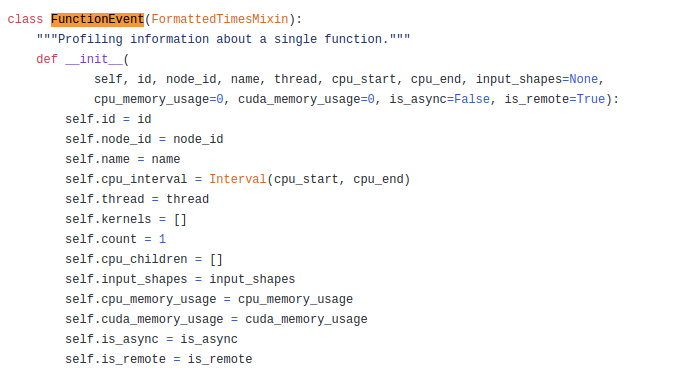

In [83]:
import random
l = [FunctionEvent(f'XXXX thread-{666+10+i}', i, "name", i, i*1000, i*1200) for i in range(10)]
l2 = [FunctionEvent(9999+100+i, i if random.random() < 0.4 else i+222, "CUDA name", i, i*1000+100, i*1200-100) for i in range(10)]
l.extend(l2)

for i, e in enumerate(l):
    cude, start, end = random.randint(8, 10), i*1000+10, i*1200-10
    e.append_kernel(f"add", cude, start, end)
    start, end = i*1000+100, i*1200-100
    e.append_kernel(f"sub_add {i}", cude, start, end)

ev=EventList(l)

with tempfile.NamedTemporaryFile(mode="w+") as f:
            print(f"writed to {f.name}")
            ev.export_chrome_trace(f.name)
            # read the trace and expect valid json
            # if the JSON generated by export_chrome_trace is not valid, this will throw and fail the test.
            print(f.read())
            print("readed")
            parsed = json.load(f)
            print(json.dumps(parsed, sort_keys=True)) #indent=4))
            print(ev.table())

writed to /tmp/tmphczt1j5a
[{"name": "name", "ph": "X", "ts": 0, "dur": 0, "tid": " node_id:0, thread_id:0 ", "pid": "CPU functions", "args": {}}, {"name": "name", "ph": "s", "ts": 0, "tid": 0, "pid": "CPU functions", "id": 0, "cat": "cpu_to_cuda", "args": {}}, {"name": "add", "ph": "f", "ts": 10, "tid": 9, "pid": "CUDA functions", "id": 0, "cat": "cpu_to_cuda", "args": {}}, {"name": "add", "ph": "X", "ts": 10, "dur": -20, "tid": 9, "pid": "CUDA functions", "args": {}}, {"name": "name", "ph": "s", "ts": 0, "tid": 0, "pid": "CPU functions", "id": 1, "cat": "cpu_to_cuda", "args": {}}, {"name": "sub_add 0", "ph": "f", "ts": 100, "tid": 9, "pid": "CUDA functions", "id": 1, "cat": "cpu_to_cuda", "args": {}}, {"name": "sub_add 0", "ph": "X", "ts": 100, "dur": -200, "tid": 9, "pid": "CUDA functions", "args": {}}, {"name": "name", "ph": "X", "ts": 1000, "dur": 200, "tid": " node_id:1, thread_id:1 ", "pid": "CPU functions", "args": {}}, {"name": "name", "ph": "s", "ts": 1000, "tid": 1, "pid": "

JSONDecodeError: Expecting value: line 1 column 1 (char 0)